In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, chi2

In [3]:
# Train results
train_auc = np.load('../model_metrics/exp1/train_auc_all.npy')
train_fpr = np.load('../model_metrics/exp1/train_fpr_all.npy')
train_scores = np.load('../model_metrics/exp1/train_scores.npy')
train_thresh = np.load('../model_metrics/exp1/train_thresholds_all.npy')
train_tpr = np.load('../model_metrics/exp1/train_tpr_all.npy')

# Test results
test_auc = np.load('../model_metrics/exp1/test_auc_all.npy')
test_fpr = np.load('../model_metrics/exp1/test_fpr_all.npy')
test_scores = np.load('../model_metrics/exp1/test_scores.npy')
test_thresh = np.load('../model_metrics/exp1/test_thresholds_all.npy')
test_tpr = np.load('../model_metrics/exp1/test_tpr_all.npy')

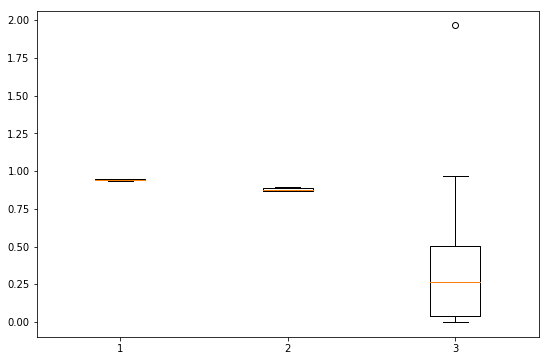

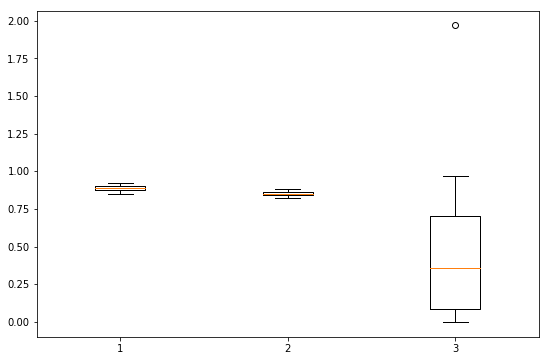

In [22]:
train_data_to_plot = [train_auc, train_scores, train_thresh]
test_data_to_plot = [test_auc, test_scores, test_thresh]



# Create a figure instance
fig1 = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig1.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(train_data_to_plot)
plt.show(fig1)


# Create a figure instance
fig2 = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig2.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(test_data_to_plot)
plt.show(fig2)

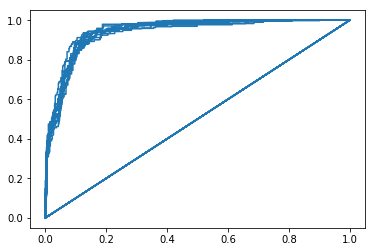

In [20]:
plt.plot(1-train_fpr, 1-train_tpr)

In [23]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# put parent dir in path
sys.path.insert(0,'..')

In [25]:
# get exp num
while True:
    try:
        exp_num = int(input())
        break
    except ValueError:
        print("Must be an integer")

metrics_path = os.path.join("..", "model_metrics", "exp" + str(exp_num))

1


# Train and Test Metrics

In [154]:
def reindex_thresh(tpr, fpr, thresh):
    # get thresh to reindex by
    thresh_lens = np.array([i.shape[0] for i in thresh])
    rein_thresh = thresh[np.argmax(thresh_lens)]

    # reindex all these values so we are using the same thresholds
    for i in range(thresh.shape[0]):
        df = pd.DataFrame(columns=['fpr', 'tpr', 'thresh'])
        df['fpr'] = fpr[i]
        df['tpr'] = tpr[i]
        df['thresh'] = thresh[i]

        df = df.set_index('thresh').reindex(index=rein_thresh, method='nearest').reset_index()
        fpr[i] = df['fpr'][:, None]
        tpr[i] = df['tpr'][:, None]
        thresh[i] = df['thresh'][:, None]

    fpr = np.hstack(fpr).T
    tpr = np.hstack(tpr).T
    thresh = np.hstack(thresh).T
    
    return tpr, fpr, thresh

def get_theta_star(tpr, fpr, thresh):
    # get theta*
    best_thresh_inds = np.argmax(np.square(tpr) + np.square(1 - fpr), axis=1)
    best_threshs = thresh[np.arange(10), best_thresh_inds]
    
    return best_threshs, best_thresh_inds

def get_best_sens_spec(tpr, fpr, best_thresh_inds):
    # get sens/spec
    sens = 1 - fpr[np.arange(10), best_thresh_inds]
    spec = tpr[np.arange(10), best_thresh_inds]
    
    return sens, spec

def plot_metrics(data_to_plot):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score', 'Train AUC', 
                        'Train Specificity', 'Train Sensitivity',
                        'Test Score', 'Test AUC',
                        'Test Specificity', 'Test Sensitivity'])
    plt.xticks(rotation=45)
    plt.show(fig1)

def plot_theta_star(theta_data):
    title = 'Train and Test Best Threshold'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)    


def plot_all(data_to_plot, theta_data):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure(figsize=(10,2))
    # Create an axes instance
    ax = fig1.add_subplot(121)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score', 'Train AUC', 
                        'Train Specificity', 'Train Sensitivity',
                        'Test Score', 'Test AUC',
                        'Test Specificity', 'Test Sensitivity'])
    plt.xticks(rotation=45)
    
    title = 'Train and Test Best Threshold'
    # Create an axes instance
    ax = fig1.add_subplot(122)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)  


def plot_roc(train, tpr, fpr):
    
    if train:
        title = 'Train ROC'
    else:
        title = 'Test ROC'
    avg_tpr = np.average(tpr, axis=0)
    avg_fpr = np.average(fpr, axis=0)
    tpr_std = np.std(tpr, axis=0)
    fpr_std = np.std(fpr, axis=0)
#     for i in range(tpr.shape[0]):
#         plt.plot(fpr[i], tpr[i], 'b')
    plt.title(title)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(avg_fpr, avg_tpr, 'r')
    plt.plot(np.add(avg_fpr, fpr_std), np.add(avg_tpr, tpr_std), 'k')
    plt.plot(np.add(avg_fpr, -1*fpr_std), np.add(avg_tpr, -1*tpr_std), 'k')
    plt.show()

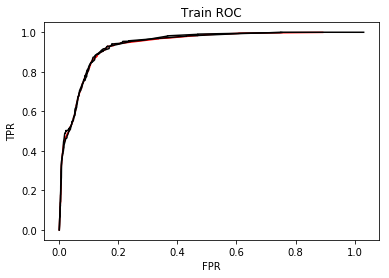

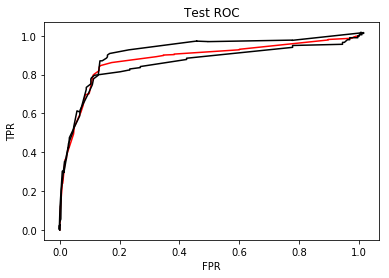

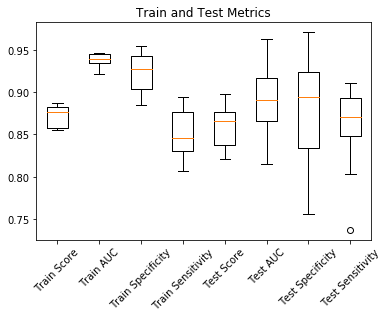

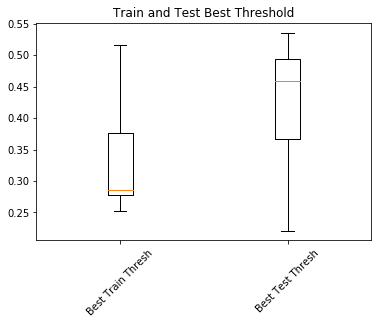

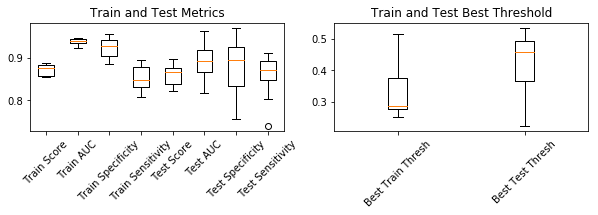

In [155]:
metric_data_to_plot = []
theta_data = []
for t in ['train', 'test']:
    scores = np.load(os.path.join(metrics_path, t+"_scores.npy"), allow_pickle=True)
    scores = [i[0] for i in scores]
    auc = np.load(os.path.join(metrics_path, t+"_auc_all.npy"), allow_pickle=True)
    auc = [i[0] for i in auc]
    fpr = np.load(os.path.join(metrics_path, t+"_fpr_all.npy"), allow_pickle=True)
    tpr = np.load(os.path.join(metrics_path, t+"_tpr_all.npy"), allow_pickle=True)
    thresh = np.load(os.path.join(metrics_path, t+"_thresholds_all.npy"), allow_pickle=True)
    tpr_reindexed, fpr_reindexed, thresh_reindexed = reindex_thresh(tpr, fpr, thresh)
    best_threshs, best_thresh_inds = get_theta_star(tpr_reindexed, fpr_reindexed, thresh_reindexed)
    sens, spec = get_best_sens_spec(tpr_reindexed, fpr_reindexed, best_thresh_inds)
    train = t == 'train'
    plot_roc(train, tpr_reindexed, fpr_reindexed)
    metric_data_to_plot.append(scores)
    metric_data_to_plot.append(auc)
    metric_data_to_plot.append(spec)
    metric_data_to_plot.append(sens)
    theta_data.append(best_threshs)

plot_metrics(metric_data_to_plot)
plot_theta_star(theta_data)
plot_all(metric_data_to_plot, theta_data)

In [58]:
train_scores = np.load('../model_metrics/exp1/train_scores.npy')
print(train_scores)

test_scores = np.load('../model_metrics/exp1/test_scores.npy')
print(test_scores)

[[0.85493827]
 [0.87891441]
 [0.88719512]
 [0.85523614]
 [0.8744856 ]
 [0.87759336]
 [0.8852459 ]
 [0.85950413]
 [0.85640496]
 [0.88360324]]
[[0.8974359 ]
 [0.8525641 ]
 [0.83333333]
 [0.87179487]
 [0.87820513]
 [0.82051282]
 [0.86538462]
 [0.86538462]
 [0.89102564]
 [0.83333333]]
